<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P6: Classifiez automatiquement des biens de consommation </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 2: Classification supervisée via les données images** </span> </font>  

**Contexte**  
**Place de marché** est une entreprise qui propose souhaite lancer une marketplace e-commerce.
<img src="PlaceDeMarche.png" width="400" height="200">
**Mission**   
* **Partie 1:**  
Réaliser une première **étude de faisabilité** de regroupement des produits de même catégorie via les descriptions ;
    * **1. textuelle** 
    * **2. image**  
    * **3. textuelle et image**
de ces produits.
* **Partie 2:**  
Réaliser une **classification supervisée** à partir des images **avec des techniques classiques**;
    * **1. sans data augmentation**
    * **2. avec data augmentation**
* **Partie 3:**  
Réaliser une **classification supervisée** à partir des images **avec des techniques recentes**;
    * **1. sans data augmentation**
    * **2. avec data augmentation**
* **Partie 4:**  
Réalisation d'une collecte de données via **API**. 

Dans ce notebook, nous procédons à une classification supervisée des produits via les données images par des techniques classiques:
* une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images.

# Importation des données et des librairies Python pour DS

In [1]:
# ------------------------------------------
# projet : données des produits de Place de marché
# Auteur : Rim BAHROUN
# Date: Fevrier 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve

from glob import glob
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
from sklearn import cluster, metrics

In [57]:
data_0 = pd.read_csv('./data/Traited/data_categories_image.csv')
data_0.head()

,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,./data/Images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,./data/Images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,./data/Images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,./data/Images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,./data/Images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,4


In [4]:
data_0.groupby("label").count()

,uniq_id,image_path,label_name
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


Baby Care


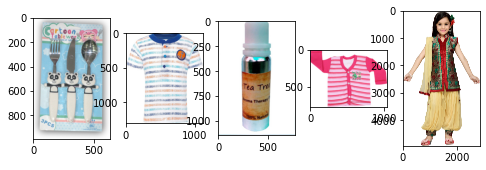

Beauty and Personal Care


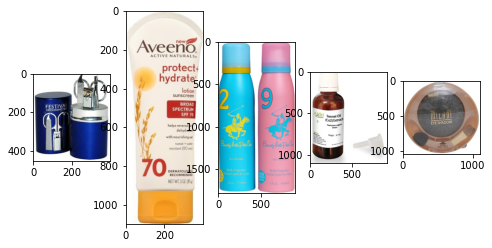

Computers


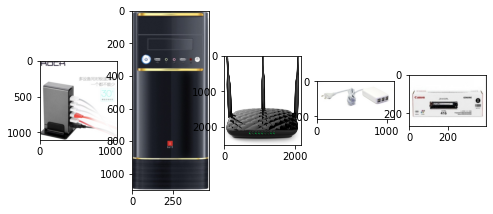

Home Decor & Festive Needs


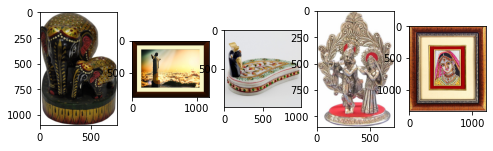

Home Furnishing


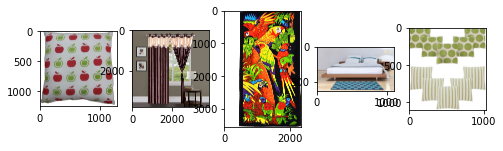

Kitchen & Dining


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


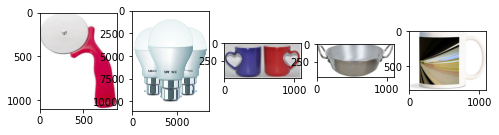

Watches


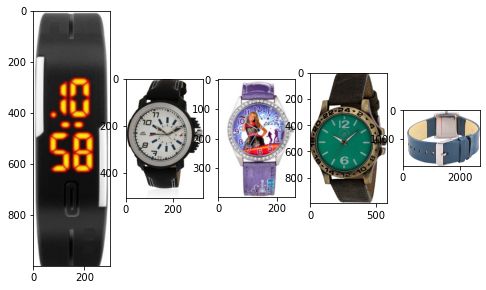

In [9]:
data = data_0
data['label_name'] = data['label_name'].astype('category')
list_labels = list(data['label_name'].cat.categories)
# revoie la liste des images dans la catégorie name
def list_fct(name) :
    list_image_name = list(data.loc[data["label_name"]==name, "image_path"])
    return list_image_name

for name in list_labels :
    plt.figure(figsize=(8, 8))
    print(name)
    # print("-------")
    for i in range(5):
        plt.subplot(150 + 1 + i)
        filename = np.random.choice(list_fct(name), 1)[0]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [21]:
data_0.head(2)

,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,./data/Images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,./data/Images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,0


In [61]:
X = data_0.iloc[:,1:-1]
y = data_0.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

data_ = np.concatenate((X_train, y_train.to_numpy().reshape(-1, 1)), axis=1)
data = pd.DataFrame(data_, columns=list(X.columns) + ['label'])
data_test_ = np.concatenate((X_test, y_test.to_numpy().reshape(-1, 1)), axis=1)
data_test = pd.DataFrame(data_test_, columns=list(X.columns) + ['label'])

In [64]:
print(data.shape)
data.head(2)

(900, 3)


,image_path,label_name,label
0,./data/Images/c7207128c680a437e1cad834a8880007...,Watches,6
1,./data/Images/417ae3e8b08acc19a023b8a958644799...,Beauty and Personal Care,1


In [65]:
print(data_test.shape)
data_test.head(2)

(150, 3)


,image_path,label_name,label
0,./data/Images/833a87b0af3b84fe246d2ebf271af177...,Computers,2
1,./data/Images/55195de3873fffaa9e37b041533d7305...,Kitchen & Dining,5


In [66]:
data.groupby("label").count()

,image_path,label_name
label,,
0,131,131
1,137,137
2,121,121
3,129,129
4,122,122
5,128,128
6,132,132


In [67]:
data_test.groupby("label").count()

,image_path,label_name
label,,
0,19,19
1,13,13
2,29,29
3,21,21
4,28,28
5,22,22
6,18,18


In [2]:
# data.to_csv('./data/Traited/dataset_train.csv', index=False)
# data_test.to_csv('./data/Traited/dataset_test.csv', index=False)
data = pd.read_csv('./data/Traited/dataset_train.csv')
data_test = pd.read_csv('./data/Traited/dataset_test.csv')

# Création du modèle de classification

Cette fonction create_model_fct() retourne un modèle CNN pré-entraîné basé sur l'architecture VGG16 avec un nouveau classifieur ajouté. Le modèle est chargé avec les poids entraînés sur l'ensemble de données ImageNet. Seuls les derniers couches du modèle sont entraînables et les poids des couches de convolution sont figés. Le modèle est compilé avec une fonction de perte categorical_crossentropy et l'optimiseur rmsprop. Enfin, la fonction retourne le modèle.

In [7]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# Approche préparation initiale des images

In [3]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(900, 224, 224, 3)


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(150, 224, 224, 3)


In [4]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(675, 224, 224, 3)

In [8]:
# Création du modèle
with tf.device('/cpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/cpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 6.2279 - accuracy: 0.4044 
Epoch 1: val_loss improved from inf to 1.42721, saving model to .\model1_best_weights.h5
11/11 [==============================] - 189s 18s/step - loss: 6.2279 - accuracy: 0.4044 - val_loss: 1.4272 - val_accuracy: 0.7333
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 2.2997 - accuracy: 0.6637 
Epoch 2: val_loss improved from 1.42721 to 1.11019, saving model to .\model1_best_weights.h5
11/11 [==============================] - 167s 16s/step - loss: 2.2997 - accuracy: 0.6637 - val_loss: 1.1102 - val_accuracy: 0.7778
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.2811 - accuracy: 0.7570 
Epoch 3: val_loss improved from 1.11019 to 1.06115, saving model to .\model1_best_weights.h5
11/11 [==============================] - 149s 14s/step - loss: 1.2811 - accuracy: 0.7570 - val_loss: 1.0612 - val_accuracy: 0.7689
Epoch 4/50
11/11 [=============================

In [10]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

22/22 [==============================] - 104s 5s/step - loss: 0.0046 - accuracy: 1.0000
Training Accuracy: 1.0000

8/8 [==============================] - 37s 4s/step - loss: 0.8737 - accuracy: 0.8133
Validation Accuracy:  0.8133


In [11]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8222
Test Accuracy       :  0.7933


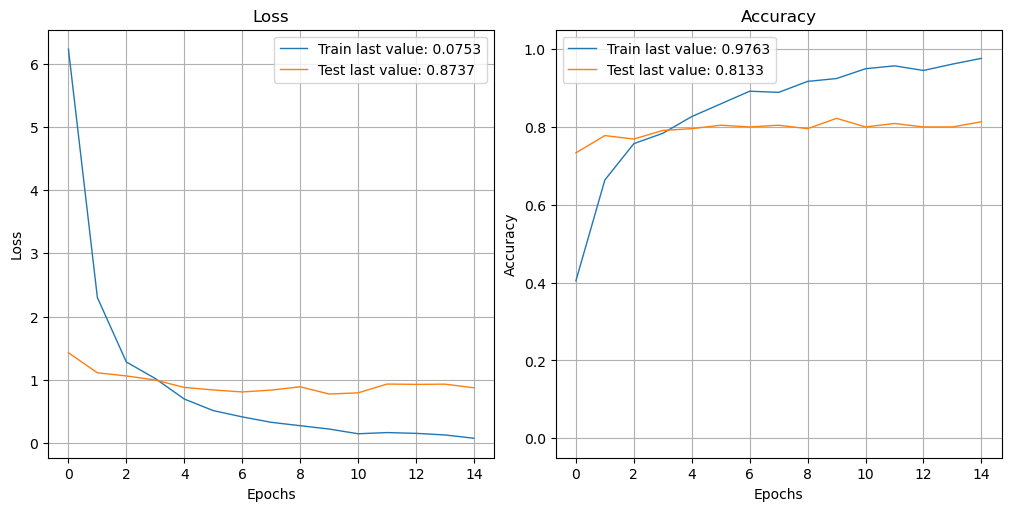

In [12]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [13]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

8/8 [==============================] - 40s 4s/step
[2 2 3 0 1 5 3 6 3 4 0 1 5 2 3 5 4 1 2 4 3 0 4 2 2 5 3 2 5 1 3 0 0 2 5 5 1
 2 1 2 2 0 3 6 4 6 5 4 6 1 6 0 5 5 5 1 0 2 6 4 0 0 5 6 3 1 0 6 1 1 6 3 0 0
 3 1 4 4 6 0 2 0 6 3 2 6 4 0 4 5 6 2 0 1 0 3 2 3 5 3 5 0 0 5 3 6 5 1 1 0 5
 6 3 0 2 2 5 1 0 1 1 4 6 0 6 1 1 4 4 0 5 4 4 3 4 1 3 6 3 5 1 2 6 4 6 2 4 5
 1 2 6 6 5 0 1 6 2 3 0 1 3 0 5 1 5 3 4 4 2 6 6 4 1 0 1 5 0 3 4 5 5 0 3 4 6
 1 5 5 2 4 1 2 4 5 3 1 2 6 6 5 6 1 4 2 0 2 6 3 4 1 3 6 3 3 2 4 4 4 3 3 6 1
 6 0 2]

[2 2 3 0 1 5 4 6 3 4 0 1 5 3 3 5 4 1 2 4 0 4 4 1 2 5 3 2 1 1 3 4 0 2 5 5 1
 2 1 2 2 0 3 6 4 6 5 4 6 1 2 0 5 5 5 1 4 1 6 4 0 0 5 6 3 2 0 6 1 1 6 3 1 0
 5 1 0 4 6 0 2 0 6 0 2 6 4 0 4 5 6 2 0 3 4 3 5 3 5 3 5 0 0 5 3 6 5 1 1 0 1
 6 5 0 2 2 4 1 0 2 5 4 6 0 6 1 1 1 4 0 5 0 4 3 4 1 3 6 3 3 2 2 6 0 6 2 4 5
 1 2 6 6 5 0 1 6 2 4 4 1 3 0 5 1 5 3 4 4 2 6 6 4 1 0 1 5 4 3 4 5 5 0 6 4 2
 1 5 5 3 4 1 2 0 5 3 1 2 6 2 3 6 1 4 2 0 2 6 3 4 1 6 6 3 5 2 4 4 0 3 3 6 1
 6 0 2]


In [16]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[26  1  0  0  6  0  0]
 [ 0 29  3  1  0  1  0]
 [ 0  2 25  2  0  1  0]
 [ 2  0  0 23  2  3  2]
 [ 5  1  0  0 25  0  0]
 [ 0  2  0  2  1 27  0]
 [ 0  0  3  0  0  0 30]]


In [18]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [19]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[26  1  0  0  6  0  0]
 [ 0 29  3  1  0  1  0]
 [ 0  2 25  2  0  1  0]
 [ 2  0  0 23  2  3  2]
 [ 5  1  0  0 25  0  0]
 [ 0  2  0  2  1 27  0]
 [ 0  0  3  0  0  0 30]]

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        33
           1       0.83      0.85      0.84        34
           2       0.81      0.83      0.82        30
           3       0.82      0.72      0.77        32
           4       0.74      0.81      0.77        31
           5       0.84      0.84      0.84        32
           6       0.94      0.91      0.92        33

    accuracy                           0.82       225
   macro avg       0.82      0.82      0.82       225
weighted avg       0.82      0.82      0.82       225



In [21]:
data['label_name'] = data['label_name'].astype('category')
list_labels = list(data['label_name'].cat.categories)
list_labels

['Baby Care',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining',
 'Watches']

<AxesSubplot:>

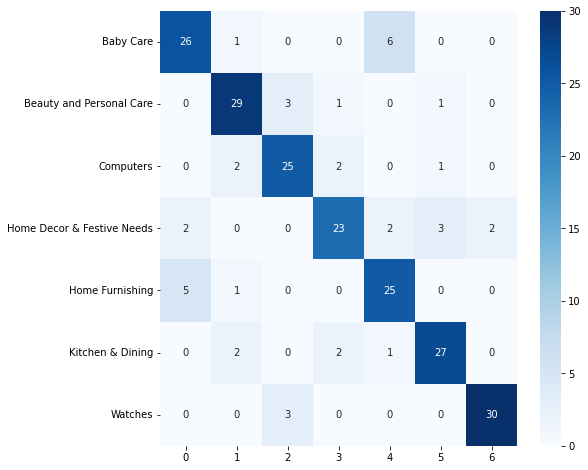

In [23]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8, 8))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

# Approche par ImageDatagenerator avec data augmentation

**ImageDataGenerator** est une classe de la bibliothèque tensorflow.keras.preprocessing.image qui permet de créer des générateurs d'images en temps réel pour l'entraînement de modèles de réseaux de neurones convolutionnels en utilisant des données d'images stockées sur le disque.

Lorsqu'on utilise **ImageDataGenerator**, on définit des transformations d'images, appelées augmentations de données, qui seront appliquées aux images d'entraînement en temps réel pendant l'entraînement du modèle. Ces augmentations de données peuvent inclure des rotations aléatoires, des translations, des changements d'échelle, des retournements horizontaux et verticaux, et d'autres techniques pour améliorer la diversité des données d'entraînement.

En utilisant **ImageDataGenerator**, on peut charger les images à la volée, en les prétraitant et en les augmentant en temps réel, ce qui permet de travailler avec des ensembles de données volumineux qui ne peuvent pas être chargés en mémoire en une seule fois. Cela permet également d'éviter le surapprentissage en augmentant la diversité des données d'entraînement.

En résumé, **ImageDataGenerator** est une classe très utile pour la préparation de données en vue de l'entraînement de modèles de réseaux de neurones convolutionnels, qui permet de charger les données à la volée, de les prétraiter et de les augmenter en temps réel en utilisant des transformations d'images.

In [19]:
# data is a Pandas DataFrame containing the image paths
# and labels of the data to be used. 
# datagen is an instance of the ImageDataGenerator class from Keras,
# which is used to augment the input data.
# data_type is a string indicating the subset of the data to use,
# either "training", "validation", or "testing".

# The function uses the flow_from_dataframe() method 
# of the datagen object to generate a Keras ImageDataGenerator object. 
# This object represents a flow of data from the data DataFrame.
# The method specifies the column names for the image paths and labels,
# the target size of the images, the batch size, and whether to shuffle the data.

# The function returns the data_flow object.
# This object can be used to train a machine learning model 
# using the fit_generator() method in Keras.

batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

**Batch size** is a hyperparameter in machine learning that determines the number of samples that are processed in a single iteration (i.e., forward and backward pass) of the training algorithm. In other words, it represents the number of training examples that are fed into the model at once during each training step.

During training, the dataset is typically divided into batches, and each batch is passed through the model to update its parameters. The batch size is an important hyperparameter because it affects both the speed and the quality of the training process.

A larger batch size means that more training examples are processed in each iteration, which can lead to faster training times, especially when using hardware accelerators like GPUs or TPUs. However, a larger batch size also requires more memory to store the intermediate calculations, which can become a limitation on certain hardware or when working with large datasets.

On the other hand, a smaller batch size may take longer to train the model but may result in a more accurate model because it allows for more frequent updates to the model's parameters and reduces the noise in the gradient estimates.

In summary, the choice of batch size in machine learning is a trade-off between training speed and model accuracy, and it often depends on the size of the dataset, available hardware, and other factors.

In [68]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

datagen_test = ImageDataGenerator(validation_split=0,
                                  preprocessing_function=preprocess_input)

# train
train_flow = data_flow_fct(data, datagen_train, data_type='training')
# validation
val_flow = data_flow_fct(data, datagen_train, data_type='validation')
# test
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 675 validated image filenames belonging to 7 classes.
Found 225 validated image filenames belonging to 7 classes.
Found 150 validated image filenames belonging to 7 classes.


datagen_train est utilisé pour augmenter les données d'entraînement, il applique une rotation aléatoire jusqu'à 20 degrés, un décalage horizontal et vertical de 20% de la taille de l'image, et des retournements horizontaux aléatoires pour augmenter la diversité des images. Il divise également les données d'entraînement en deux ensembles, l'un pour l'entraînement et l'autre pour la validation, en utilisant la validation_split à 0,25, ce qui signifie que 25% des données sont réservées pour la validation.

The above code block initializes three ImageDataGenerator objects - datagen_train, datagen_test, and datagen_val - for data augmentation and preprocessing.

**datagen_train** is used to generate batches of training data with various transformations applied, such as rotation, horizontal flipping, and shifting. It also performs data preprocessing using a function called preprocess_input.

**datagen_test** is used to generate batches of test data. Unlike datagen_train, it does not perform any data augmentation, but it does apply the same preprocessing function as datagen_train.

**datagen_val** is not explicitly defined in the code block, but it is used indirectly through the data_flow_fct function to generate batches of validation data with the same settings as datagen_train.

After initializing the ImageDataGenerator objects, the data_flow_fct function is called three times with different parameters to create three Keras ImageDataGenerator objects - train_flow, val_flow, and test_flow - which are used to feed the training, validation, and test data into the model during training.

train_flow and val_flow are generated using datagen_train and are used to generate batches of training and validation data, respectively. test_flow is generated using datagen_test and is used to generate batches of test data.

The validation_split parameter is used to specify the proportion of data that should be set aside for validation during training. In this case, 25% of the data is used for validation.

In [72]:
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [76]:
# Création du modèle
with tf.device('/cpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Dans ce code, un modèle est créé avec create_model_fct() et stocké dans la variable model2. Ensuite, un ModelCheckpoint et un EarlyStopping sont créés et stockés dans la liste callbacks_list. ModelCheckpoint permet de sauvegarder les poids du modèle avec la plus petite perte de validation (val_loss), tandis que EarlyStopping permet d'arrêter l'entraînement du modèle si la perte de validation (val_loss) n'a pas diminué après un certain nombre de patience epochs.

Notez que le modèle est configuré pour s'exécuter sur le GPU 0 à l'aide de tf.device('/gpu:0'). Si votre système n'a pas de GPU ou si vous ne souhaitez pas utiliser le GPU, vous pouvez le remplacer par tf.device('/cpu:0').m

In [77]:
with tf.device('/cpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50,
                    callbacks=callbacks_list, verbose=1)

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 3.7569 - accuracy: 0.4474
Epoch 1: val_loss improved from inf to 1.02569, saving model to .\model2_best_weights.h5
22/22 [==============================] - 190s 9s/step - loss: 3.7569 - accuracy: 0.4474 - val_loss: 1.0257 - val_accuracy: 0.7689
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 1.5276 - accuracy: 0.6696
Epoch 2: val_loss improved from 1.02569 to 0.91472, saving model to .\model2_best_weights.h5
22/22 [==============================] - 189s 9s/step - loss: 1.5276 - accuracy: 0.6696 - val_loss: 0.9147 - val_accuracy: 0.7822
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 1.1441 - accuracy: 0.7111
Epoch 3: val_loss improved from 0.91472 to 0.83050, saving model to .\model2_best_weights.h5
22/22 [==============================] - 192s 9s/step - loss: 1.1441 - accuracy: 0.7111 - val_loss: 0.8305 - val_accuracy: 0.7956
Epoch 4/50
22/22 [==============================] - E

In [78]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

22/22 [==============================] - 142s 6s/step - loss: 0.0760 - accuracy: 0.9719
Training Accuracy   : 0.9719

8/8 [==============================] - 48s 6s/step - loss: 0.9382 - accuracy: 0.8311
Validation Accuracy :  0.8311


In [79]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8311


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Accuracy       :  0.7800


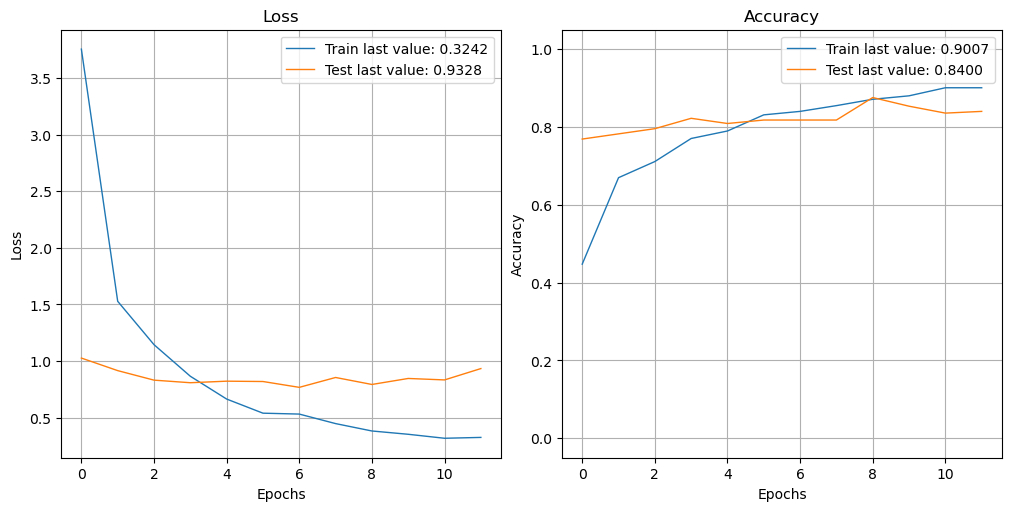

In [81]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()